# Baseline vs Ablations: Check Impact Analysis

This notebook analyzes the baseline experiment results against ablation runs where certain checks were disabled. It focuses on how the outcome of the same experiments changed when the following checks were turned off:

- no_lint
- no_tests
- no_playwright

Data sources are CSV files in `analysis/` with a common schema:
- Case identifier and Assignee
- AB-xx check columns with values in {PASS, WARN, FAIL, NA}
- Aggregate columns: `PASS#`, `WARN#`, `FAIL#`
- Free-text `Notes`

We compute two outputs for each case:
- Viability (V): 1 if AB-01 and AB-02 are not FAIL; else 0
- Quality (Q): 0–10 equal-weight average across AB checks with NA re-normalization

We will:
- Load and clean the datasets
- Summarize the baseline
- Compare each ablation to baseline with per-case deltas and aggregate trends
- Visualize mean deltas and surface the largest regressions and improvements


### Note on AB_mean_score

AB_mean_score is an auxiliary 0–1 metric computed as the simple (unweighted) mean of per‑check status scores across the AB columns, using PASS=1.0, WARN=0.5, FAIL=0.0 and excluding NA (skip‑NA mean). It is helpful for quick per‑check and per‑ablation comparisons and heatmaps. It is independent from the main outputs:
- Viability (V): binary gate from AB‑01/AB‑02
- Quality (Q): 0–10 equal‑weight average across AB checks with NA re‑normalization


In [3]:
from __future__ import annotations

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_colwidth", 200)

# Resolve data directory robustly by probing common locations
CANDIDATES: List[Path] = [
    Path.cwd(),
    Path.cwd() / "analysis",
]
if "__file__" in globals():
    CANDIDATES.append(Path(__file__).parent)

DATA_DIR: Path | None = None
for cand in CANDIDATES:
    if cand and (cand / "app.build-neurips25 - baseline.csv").exists():
        DATA_DIR = cand
        break
if DATA_DIR is None:
    raise FileNotFoundError("Could not locate data directory; expected CSVs under ./analysis or CWD.")

FILES = {
    "baseline": DATA_DIR / "app.build-neurips25 - baseline.csv",
    "no_lint": DATA_DIR / "app.build-neurips25 - ablations_no_lint.csv",
    "no_playwright": DATA_DIR / "app.build-neurips25 - ablations_no_playwright.csv",
    "no_tests": DATA_DIR / "app.build-neurips25 - ablations_no_tests.csv",
}

AB_COLUMNS = [
    "AB-01 Boot",
    "AB-02 Prompt",
    "AB-03 Create",
    "AB-04 View/Edit",
    "AB‑06 Clickable Sweep",
    "AB‑07 Performance >75",
]

# Normalize AB column names (unify hyphens and drop AB-05 if present)
AB_NORMALIZE = {
    "AB–01 Boot": "AB-01 Boot",
    "AB—01 Boot": "AB-01 Boot",
    "AB‑01 Boot": "AB-01 Boot",
    "AB‑02 Prompt": "AB-02 Prompt",
    "AB–02 Prompt": "AB-02 Prompt",
    "AB—02 Prompt": "AB-02 Prompt",
    "AB‑03 Create": "AB-03 Create",
    "AB‑04 View/Edit": "AB-04 View/Edit",
    "AB‑06 Clickable Sweep": "AB‑06 Clickable Sweep",
    "AB‑07 Performance >75": "AB‑07 Performance >75",
    "AB-05 UI Sweep": None,
    "AB‑05 UI Sweep": None,
}

AGG_COLUMNS = ["PASS#", "WARN#", "FAIL#"]
KEY_COLUMN = "Case"

STATUS_ORDER = ["FAIL", "WARN", "NA", "PASS"]  # ordered for ordinal mapping
STATUS_TO_SCORE = {"FAIL": 0, "WARN": 0.5, "NA": np.nan, "PASS": 1.0}


def normalize_ab_columns(df: pd.DataFrame) -> pd.DataFrame:
    # unify column names and drop AB-05 variants
    rename_map = {c: AB_NORMALIZE[c] for c in df.columns if c in AB_NORMALIZE and AB_NORMALIZE[c]}
    df = df.rename(columns=rename_map)
    drop_cols = [c for c in df.columns if c in AB_NORMALIZE and AB_NORMALIZE[c] is None]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    return df


def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # unify column names (strip spaces) and types
    df.columns = [c.strip() for c in df.columns]
    # ensure numeric columns are numeric
    for col in AGG_COLUMNS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # key normalization
    df[KEY_COLUMN] = df[KEY_COLUMN].astype(str)
    return df


def score_status_columns(df: pd.DataFrame) -> pd.DataFrame:
    scored = df.copy()
    for col in AB_COLUMNS:
        if col in scored.columns:
            scored[f"{col}__score"] = scored[col].map(STATUS_TO_SCORE)
        else:
            scored[f"{col}__score"] = np.nan
    scored["AB_mean_score"] = scored[[f"{c}__score" for c in AB_COLUMNS]].mean(axis=1, skipna=True)
    return scored


# Load all datasets
raw: Dict[str, pd.DataFrame] = {k: load_csv(v) for k, v in FILES.items()}
scored: Dict[str, pd.DataFrame] = {k: score_status_columns(df) for k, df in raw.items()}

# Align on common cases present in baseline for fair comparison
baseline_cases = set(scored["baseline"][KEY_COLUMN])
for k in list(scored.keys()):
    scored[k] = scored[k][scored[k][KEY_COLUMN].isin(baseline_cases)].reset_index(drop=True)

len(baseline_cases), {k: len(v) for k, v in scored.items()}


(30, {'baseline': 30, 'no_lint': 30, 'no_playwright': 30, 'no_tests': 30})

In [4]:
# Compute Viability (V) and Quality (Q) per new spec

GATE_FAIL_COLUMNS = ["AB-01 Boot", "AB-02 Prompt"]

# Equal weights across AB checks; NA re-normalization happens via mean with skipna
QUALITY_MAP = {
    "AB-01 Boot": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-02 Prompt": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-03 Create": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-04 View/Edit": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB‑06 Clickable Sweep": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    # AB‑07 Performance >75 is a binary proxy of performance; map as before for legacy CSVs
    "AB‑07 Performance >75": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
}


def compute_viability(row: pd.Series) -> int:
    for col in GATE_FAIL_COLUMNS:
        if col in row and str(row[col]) == "FAIL":
            return 0
    return 1


def compute_quality(row: pd.Series) -> float:
    scores = []
    for col, mapping in QUALITY_MAP.items():
        if col in row:
            scores.append(mapping.get(str(row[col]), np.nan))
    if len(scores) == 0:
        return np.nan
    return float(np.nanmean(scores) * 10.0)

# Apply to all datasets
for k in list(scored.keys()):
    df = scored[k]
    scored[k]["V"] = df.apply(compute_viability, axis=1)
    scored[k]["Q"] = df.apply(compute_quality, axis=1)

# Quick sanity: show mean Q and viability rate per table
{ k: {"mean_Q": float(scored[k]["Q"].mean()), "viability_rate": float(scored[k]["V"].mean())} for k in scored }


{'baseline': {'mean_Q': 8.058333333333332,
  'viability_rate': 0.7333333333333333},
 'no_lint': {'mean_Q': 8.252777777777776, 'viability_rate': 0.8},
 'no_playwright': {'mean_Q': 8.619444444444445, 'viability_rate': 0.9},
 'no_tests': {'mean_Q': 7.791666666666666, 'viability_rate': 0.8}}

In [5]:
# Baseline summary
base = scored["baseline"].copy()

# Aggregate means
baseline_agg = base[AGG_COLUMNS + ["AB_mean_score", "Q", "V"]].mean(numeric_only=True).to_frame("mean").T
# Status counts per AB column
status_counts = {}
for col in AB_COLUMNS:
    if col in base.columns:
        status_counts[col] = base[col].value_counts().reindex(STATUS_ORDER).fillna(0).astype(int)
status_counts_df = pd.DataFrame(status_counts).T

print("Baseline aggregate means (PASS#/WARN#/FAIL#, AB_mean_score, Q, V):")
baseline_agg


Baseline aggregate means (PASS#/WARN#/FAIL#, AB_mean_score, Q, V):


,PASS#,WARN#,FAIL#,AB_mean_score,Q,V
mean,4.266667,0.466667,0.333333,0.805833,8.058333,0.733333


In [6]:
# Compute deltas vs baseline for each ablation

def compute_deltas_vs_baseline(baseline: pd.DataFrame, variant: pd.DataFrame, label: str) -> pd.DataFrame:
    b = baseline[[KEY_COLUMN, "AB_mean_score", "Q", "V"] + [f"{c}__score" for c in AB_COLUMNS]].copy()
    v = variant[[KEY_COLUMN, "AB_mean_score", "Q", "V"] + [f"{c}__score" for c in AB_COLUMNS]].copy()
    merged = b.merge(v, on=KEY_COLUMN, suffixes=("_base", f"_{label}"))

    # Per-case deltas
    merged[f"delta_AB_mean_score_{label}"] = merged[f"AB_mean_score_{label}"] - merged["AB_mean_score_base"]
    merged[f"delta_Q_{label}"] = merged[f"Q_{label}"] - merged["Q_base"]
    merged[f"delta_V_{label}"] = merged[f"V_{label}"] - merged["V_base"]
    for c in AB_COLUMNS:
        merged[f"delta_{c}__score_{label}"] = merged[f"{c}__score_{label}"] - merged[f"{c}__score_base"]

    return merged


deltas = {}
base_df = scored["baseline"].copy()
for label in ["no_lint", "no_tests", "no_playwright"]:
    deltas[label] = compute_deltas_vs_baseline(base_df, scored[label], label)

# Aggregate mean deltas per ablation
mean_deltas = []
for label, df in deltas.items():
    row = {
        "ablation": label,
        "mean_delta_AB_mean_score": df[f"delta_AB_mean_score_{label}"].mean(),
        "mean_delta_Q": df[f"delta_Q_{label}"].mean(),
        "mean_delta_V": df[f"delta_V_{label}"].mean(),
    }
    for c in AB_COLUMNS:
        row[f"mean_delta_{c}__score"] = df[f"delta_{c}__score_{label}"].mean()
    mean_deltas.append(row)

mean_deltas_df = pd.DataFrame(mean_deltas)
mean_deltas_df


,ablation,mean_delta_AB_mean_score,mean_delta_Q,mean_delta_V,mean_delta_AB-01 Boot__score,mean_delta_AB-02 Prompt__score,mean_delta_AB-03 Create__score,mean_delta_AB-04 View/Edit__score,mean_delta_AB‑06 Clickable Sweep__score,mean_delta_AB‑07 Performance >75__score
0,no_lint,0.019444,0.194444,0.066667,0.033333,0.076923,-0.045455,-0.041667,0.000000,0.020000
1,no_tests,-0.026667,-0.266667,0.066667,-0.016667,0.108696,-0.052632,-0.200000,0.095238,-0.045455
2,no_playwright,0.056111,0.561111,0.166667,0.016667,0.096154,-0.020833,0.033333,0.000000,0.000000


In [7]:
# Viability (V) impact per ablation
viability_rows = []
for label, df in deltas.items():
    v_delta = df[f"delta_V_{label}"]
    viability_rows.append({
        "ablation": label,
        "mean_delta_V": v_delta.mean(skipna=True),
        "nonviable_to_viable": int((v_delta > 0).sum()),
        "viable_to_nonviable": int((v_delta < 0).sum()),
    })
viability_impact_df = pd.DataFrame(viability_rows).sort_values("ablation")
viability_impact_df


,ablation,mean_delta_V,nonviable_to_viable,viable_to_nonviable
0,no_lint,0.066667,4,2
2,no_playwright,0.166667,6,1
1,no_tests,0.066667,7,5


/var/folders/sv/6zmvf1bj5xq5vgv9ptjr_0x40000gp/T/ipykernel_72519/2698360851.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_AB_mean_score", ax=axes[0], palette="Set2")
/var/folders/sv/6zmvf1bj5xq5vgv9ptjr_0x40000gp/T/ipykernel_72519/2698360851.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_Q", ax=axes[1], palette="Set2")


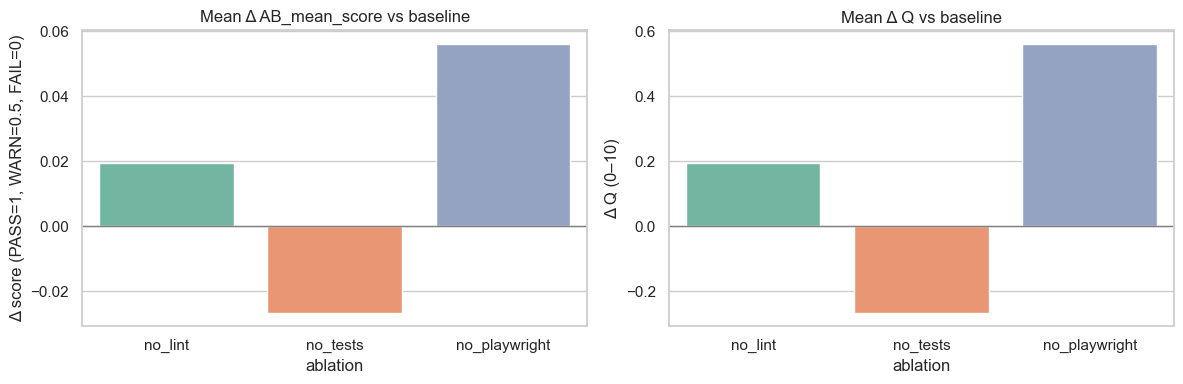

,ablation
0,no_lint


,Case,delta_AB_mean_score,ablation
4,bookmark-management-app_trpc-agent_claude_gemini,-0.750,no_lint
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-0.400,no_lint
2,birthday-wish-app_trpc-agent_claude_gemini,-0.375,no_lint
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-0.200,no_lint
24,recipe-sharing-platform_trpc-agent_claude_gemini,-0.200,no_lint


,Case,delta_Q,ablation
4,bookmark-management-app_trpc-agent_claude_gemini,-7.50,no_lint
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-4.00,no_lint
2,birthday-wish-app_trpc-agent_claude_gemini,-3.75,no_lint
24,recipe-sharing-platform_trpc-agent_claude_gemini,-2.00,no_lint
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-2.00,no_lint


,ablation
0,no_tests


,Case,delta_AB_mean_score,ablation
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-1.000000,no_tests
18,pastel-blue-notes-app_trpc-agent_claude_gemini,-0.916667,no_tests
28,todo-list-with-mood_trpc-agent_claude_gemini,-0.916667,no_tests
4,bookmark-management-app_trpc-agent_claude_gemini,-0.750000,no_tests
24,recipe-sharing-platform_trpc-agent_claude_gemini,-0.583333,no_tests


,Case,delta_Q,ablation
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-10.000000,no_tests
18,pastel-blue-notes-app_trpc-agent_claude_gemini,-9.166667,no_tests
28,todo-list-with-mood_trpc-agent_claude_gemini,-9.166667,no_tests
4,bookmark-management-app_trpc-agent_claude_gemini,-7.500000,no_tests
24,recipe-sharing-platform_trpc-agent_claude_gemini,-5.833333,no_tests


,ablation
0,no_playwright


,Case,delta_AB_mean_score,ablation
2,birthday-wish-app_trpc-agent_claude_gemini,-0.500000,no_playwright
12,gym-crm_trpc-agent_claude_gemini,-0.500000,no_playwright
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-0.300000,no_playwright
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-0.166667,no_playwright
4,bookmark-management-app_trpc-agent_claude_gemini,-0.150000,no_playwright


,Case,delta_Q,ablation
2,birthday-wish-app_trpc-agent_claude_gemini,-5.000000,no_playwright
12,gym-crm_trpc-agent_claude_gemini,-5.000000,no_playwright
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-3.000000,no_playwright
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-1.666667,no_playwright
4,bookmark-management-app_trpc-agent_claude_gemini,-1.500000,no_playwright


In [8]:
# Visualization: mean deltas and worst-case drops
sns.set_theme(style="whitegrid")

# Barplot of mean delta AB_mean_score and Q
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_AB_mean_score", ax=axes[0], palette="Set2")
axes[0].axhline(0, color="gray", linewidth=1)
axes[0].set_title("Mean Δ AB_mean_score vs baseline")
axes[0].set_ylabel("Δ score (PASS=1, WARN=0.5, FAIL=0)")

sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_Q", ax=axes[1], palette="Set2")
axes[1].axhline(0, color="gray", linewidth=1)
axes[1].set_title("Mean Δ Q vs baseline")
axes[1].set_ylabel("Δ Q (0–10)")
plt.tight_layout()
plt.show()

# Identify worst-case drops per ablation by AB_mean_score and Q
worst_rows = []
for label, df in deltas.items():
    row_score = df.sort_values(f"delta_AB_mean_score_{label}").head(5)[[KEY_COLUMN, f"delta_AB_mean_score_{label}"]]
    row_score["ablation"] = label
    row_q = df.sort_values(f"delta_Q_{label}").head(5)[[KEY_COLUMN, f"delta_Q_{label}"]]
    row_q["ablation"] = label
    worst_rows.append((label, row_score, row_q))

# Show top 5 worst Δ by AB_mean_score and Q for each ablation
for label, w_score, w_q in worst_rows:
    display(pd.DataFrame({"ablation": [label]}))
    display(w_score.rename(columns={f"delta_AB_mean_score_{label}": "delta_AB_mean_score"}))
    display(w_q.rename(columns={f"delta_Q_{label}": "delta_Q"}))


In [9]:
# Overall Quality (Q) impact per ablation

overall_impact_rows = []
change_breakdowns = []

for label, df in deltas.items():
    q_delta = df[f"delta_Q_{label}"]
    overall_impact_rows.append({
        "ablation": label,
        "total_delta_Q": q_delta.sum(skipna=True),
        "mean_delta_Q": q_delta.mean(skipna=True),
        "median_delta_Q": q_delta.median(skipna=True),
        "num_improved": int((q_delta > 0).sum()),
        "num_unchanged": int((q_delta == 0).sum()),
        "num_regressed": int((q_delta < 0).sum()),
    })
    change_breakdowns.append(
        pd.DataFrame({
            "ablation": label,
            "delta_Q": q_delta,
        })
    )

q_impact_df = pd.DataFrame(overall_impact_rows).sort_values("ablation")
q_impact_df


,ablation,total_delta_Q,mean_delta_Q,median_delta_Q,num_improved,num_unchanged,num_regressed
0,no_lint,5.833333,0.194444,0.0,9,12,9
2,no_playwright,16.833333,0.561111,0.0,10,14,6
1,no_tests,-8.000000,-0.266667,0.0,11,7,12


/Users/evgenii.kniazev/projects/app.build-neurips25/.venv/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/evgenii.kniazev/projects/app.build-neurips25/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


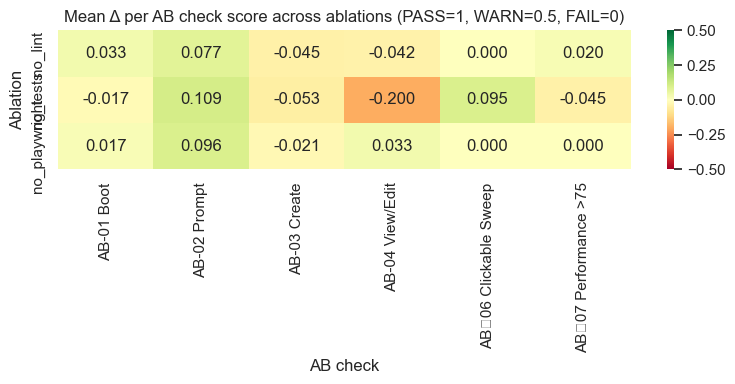


=== Status transitions for no_lint ===


,AB
0,AB-01 Boot


AB-01 Boot_no_lint,FAIL,WARN,NA,PASS
AB-01 Boot_base,,,,
FAIL,1,0,0,2
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,1,0,23


,baseline,variant,count
3,FAIL,PASS,2
7,WARN,PASS,1
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-02 Prompt


AB-02 Prompt_no_lint,FAIL,WARN,NA,PASS
AB-02 Prompt_base,,,,
FAIL,1,1,0,3
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,2,0,16


,baseline,variant,count
3,FAIL,PASS,3
13,PASS,WARN,2
1,FAIL,WARN,1
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB-03 Create


AB-03 Create_no_lint,FAIL,WARN,NA,PASS
AB-03 Create_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,2
NA,0,0,0,0
PASS,2,0,0,18


,baseline,variant,count
7,WARN,PASS,2
12,PASS,FAIL,2


,AB
0,AB-04 View/Edit


AB-04 View/Edit_no_lint,FAIL,WARN,NA,PASS
AB-04 View/Edit_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,0,2,0,9


,baseline,variant,count
13,PASS,WARN,2
7,WARN,PASS,1


,AB
0,AB‑06 Clickable Sweep


AB‑06 Clickable Sweep_no_lint,FAIL,WARN,NA,PASS
AB‑06 Clickable Sweep_base,,,,
FAIL,0,1,0,0
WARN,1,1,0,2
NA,0,0,0,0
PASS,0,2,0,16


,baseline,variant,count
7,WARN,PASS,2
13,PASS,WARN,2
1,FAIL,WARN,1
4,WARN,FAIL,1


,AB
0,AB‑07 Performance >75


AB‑07 Performance >75_no_lint,FAIL,WARN,NA,PASS
AB‑07 Performance >75_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,2
NA,0,0,0,0
PASS,0,1,0,22


,baseline,variant,count
7,WARN,PASS,2
13,PASS,WARN,1



=== Status transitions for no_tests ===


,AB
0,AB-01 Boot


AB-01 Boot_no_tests,FAIL,WARN,NA,PASS
AB-01 Boot_base,,,,
FAIL,0,0,0,3
WARN,0,1,0,1
NA,0,0,0,0
PASS,4,0,0,21


,baseline,variant,count
12,PASS,FAIL,4
3,FAIL,PASS,3
7,WARN,PASS,1


,AB
0,AB-02 Prompt


AB-02 Prompt_no_tests,FAIL,WARN,NA,PASS
AB-02 Prompt_base,,,,
FAIL,0,3,0,2
WARN,0,0,0,1
NA,0,0,0,0
PASS,1,1,0,15


,baseline,variant,count
1,FAIL,WARN,3
3,FAIL,PASS,2
7,WARN,PASS,1
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-03 Create


AB-03 Create_no_tests,FAIL,WARN,NA,PASS
AB-03 Create_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,1,1,0,16


,baseline,variant,count
7,WARN,PASS,1
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-04 View/Edit


AB-04 View/Edit_no_tests,FAIL,WARN,NA,PASS
AB-04 View/Edit_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,1,5,0,8


,baseline,variant,count
13,PASS,WARN,5
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB‑06 Clickable Sweep


AB‑06 Clickable Sweep_no_tests,FAIL,WARN,NA,PASS
AB‑06 Clickable Sweep_base,,,,
FAIL,0,1,0,0
WARN,0,1,0,3
NA,0,0,0,0
PASS,0,0,0,16


,baseline,variant,count
7,WARN,PASS,3
1,FAIL,WARN,1


,AB
0,AB‑07 Performance >75


AB‑07 Performance >75_no_tests,FAIL,WARN,NA,PASS
AB‑07 Performance >75_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,0,3,0,18


,baseline,variant,count
13,PASS,WARN,3
7,WARN,PASS,1



=== Status transitions for no_playwright ===


,AB
0,AB-01 Boot


AB-01 Boot_no_playwright,FAIL,WARN,NA,PASS
AB-01 Boot_base,,,,
FAIL,1,0,0,2
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,2,0,22


,baseline,variant,count
3,FAIL,PASS,2
13,PASS,WARN,2
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB-02 Prompt


AB-02 Prompt_no_playwright,FAIL,WARN,NA,PASS
AB-02 Prompt_base,,,,
FAIL,0,2,0,2
WARN,0,1,0,2
NA,0,0,0,0
PASS,1,1,0,17


,baseline,variant,count
1,FAIL,WARN,2
3,FAIL,PASS,2
7,WARN,PASS,2
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-03 Create


AB-03 Create_no_playwright,FAIL,WARN,NA,PASS
AB-03 Create_base,,,,
FAIL,0,0,0,0
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,0,0,21


,baseline,variant,count
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB-04 View/Edit


AB-04 View/Edit_no_playwright,FAIL,WARN,NA,PASS
AB-04 View/Edit_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,0,0,0,14


,baseline,variant,count
7,WARN,PASS,1


,AB
0,AB‑06 Clickable Sweep


AB‑06 Clickable Sweep_no_playwright,FAIL,WARN,NA,PASS
AB‑06 Clickable Sweep_base,,,,
FAIL,0,0,0,1
WARN,1,0,0,3
NA,0,0,0,0
PASS,1,2,0,17


,baseline,variant,count
7,WARN,PASS,3
13,PASS,WARN,2
3,FAIL,PASS,1
4,WARN,FAIL,1
12,PASS,FAIL,1


,AB
0,AB‑07 Performance >75


AB‑07 Performance >75_no_playwright,FAIL,WARN,NA,PASS
AB‑07 Performance >75_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,2
NA,0,0,0,0
PASS,1,0,0,23


,baseline,variant,count
7,WARN,PASS,2
12,PASS,FAIL,1


In [10]:
# Per-AB score analysis across ablations

# Build a long-form table of mean deltas per AB column and ablation
ab_mean_delta_rows = []
for label, df in deltas.items():
    row = {"ablation": label}
    for c in AB_COLUMNS:
        row[c] = df[f"delta_{c}__score_{label}"].mean()
    ab_mean_delta_rows.append(row)

ab_mean_delta_df = pd.DataFrame(ab_mean_delta_rows).set_index("ablation")[AB_COLUMNS]

# Heatmap of mean delta scores per AB
plt.figure(figsize=(8, 4))
sns.heatmap(ab_mean_delta_df, annot=True, fmt=".3f", center=0, cmap="RdYlGn", vmin=-0.5, vmax=0.5)
plt.title("Mean Δ per AB check score across ablations (PASS=1, WARN=0.5, FAIL=0)")
plt.ylabel("Ablation")
plt.xlabel("AB check")
plt.tight_layout()
plt.show()

# Transition counts: how statuses change from baseline to each ablation per AB
# We will compute a cross-tab for each AB and ablation and display top transitions
from itertools import product

TRANSITIONS_TO_SHOW = 8

for label in ["no_lint", "no_tests", "no_playwright"]:
    print(f"\n=== Status transitions for {label} ===")
    merged = scored["baseline"][[KEY_COLUMN] + AB_COLUMNS].merge(
        scored[label][[KEY_COLUMN] + AB_COLUMNS], on=KEY_COLUMN, suffixes=("_base", f"_{label}")
    )
    for c in AB_COLUMNS:
        base_s = merged[f"{c}_base"].astype(str)
        var_s = merged[f"{c}_{label}"].astype(str)
        ct = pd.crosstab(base_s, var_s).reindex(index=STATUS_ORDER, columns=STATUS_ORDER, fill_value=0)
        display(pd.DataFrame({"AB": [c]}))
        display(ct)
        # Flatten and show top transitions by count excluding unchanged PASS->PASS, WARN->WARN, FAIL->FAIL, NA->NA
        flattened = ct.stack().rename_axis(index=["baseline", "variant"]).reset_index(name="count")
        flattened = flattened[(flattened["baseline"] != flattened["variant"]) & (flattened["count"] > 0)]
        display(flattened.sort_values("count", ascending=False).head(TRANSITIONS_TO_SHOW))
